In [40]:
# Imports
import json
import requests
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
# Helpers
ENRICHR_URL = 'http://amp.pharm.mssm.edu/FlyEnrichr'
query_string = '?userListId=%s&backgroundType=%s'
gene_set_library = 'GO_Biological_Process_2018'

In [4]:
# Open gene files
files = ['matched', '48', '72']

# Add lists to FlyEnrichr
listIDs = []
for filename in files:
    file = open('Openness GO analysis/combined_' + filename + '.txt', 'r')
    text = file.read()
    file.close()
    
    description = 'combined_' + str(filename)
    payload = {
        'list': (None, text),
        'description': (None, description)
    }
    response = requests.post(ENRICHR_URL + '/addList', files=payload)
    if not response.ok:
        raise Exception('Error adding gene list')

    data = json.loads(response.text)
    listIDs.append(data['userListId'])

listIDs

[402732, 402733, 402734]

In [13]:
# Collect GO terms
go_terms = {}
for userID, group in zip(listIDs, files):
    response = requests.get(
        ENRICHR_URL + '/enrich' + query_string % (userID, gene_set_library)
     )
    if not response.ok:
        raise Exception('Error fetching enrichment results')

    data = json.loads(response.text)
    data = data[gene_set_library]
    terms = {}
    for entry in data:
        term = entry[1]
        frequency = len(entry[5])
        terms[term] = frequency
    go_terms[group] = terms
go_terms # The frequency of each term in our data

{'matched': {'larval somatic muscle development (GO:0007526)': 10,
  'post-embryonic animal organ development (GO:0048569)': 11,
  'larval central nervous system remodeling (GO:0035193)': 3,
  'imaginal disc-derived wing morphogenesis (GO:0007476)': 28,
  'eye morphogenesis (GO:0048592)': 14,
  'negative regulation of transforming growth factor beta receptor signaling pathway (GO:0030512)': 3,
  'regulation of transcription, DNA-templated (GO:0006355)': 46,
  'negative regulation of cellular macromolecule biosynthetic process (GO:2000113)': 21,
  'regulation of transcription from RNA polymerase II promoter (GO:0006357)': 46,
  'positive regulation of gene expression (GO:0010628)': 24,
  'negative regulation of cellular response to transforming growth factor beta stimulus (GO:1903845)': 3,
  'post-embryonic appendage morphogenesis (GO:0035120)': 23,
  'wing disc dorsal/ventral pattern formation (GO:0048190)': 11,
  'negative regulation of developmental process (GO:0051093)': 6,
  'compo

In [94]:
def top_terms(dic, n, label=''):
    top_n = sorted(dic, key=lambda x: dic[x], reverse=True)
    top_n = top_n[:n]
    
    GO_ids = {}
    for term in top_n:
        GO_ids[term[term.index('(')+1:term.index(')')]] = label + term
    return GO_ids

top_48 = top_terms(go_terms['48'], 50, '48_')
top_72 = top_terms(go_terms['72'], 50, '72_')

# GO 'Regulates' Relationship

In [104]:
G = nx.DiGraph()
B_first_partition_nodes = []
url = 'http://golr.berkeleybop.org/select?qt=standard&fl=*&version=2.2&wt=json&indent=on&rows=1&q=id:%22{}%22'
for term_id in top_48.keys():
    if go_terms['48'][top_48[term_id][3:]] <= 1:
        continue
    query = url.format(term_id)
    response = requests.get(query)
    data = json.loads(response.text)
    regulated_terms = data['response']['docs'][0]['regulates_closure']
    
    for r_term in regulated_terms:
        if r_term in top_72.keys():
            if not G.has_node(top_48[term_id]):
                G.add_node(top_48[term_id])
                B_first_partition_nodes.append(top_48[term_id])
            G.add_node(top_72[r_term])
            G.add_edge(top_48[term_id], top_72[r_term])

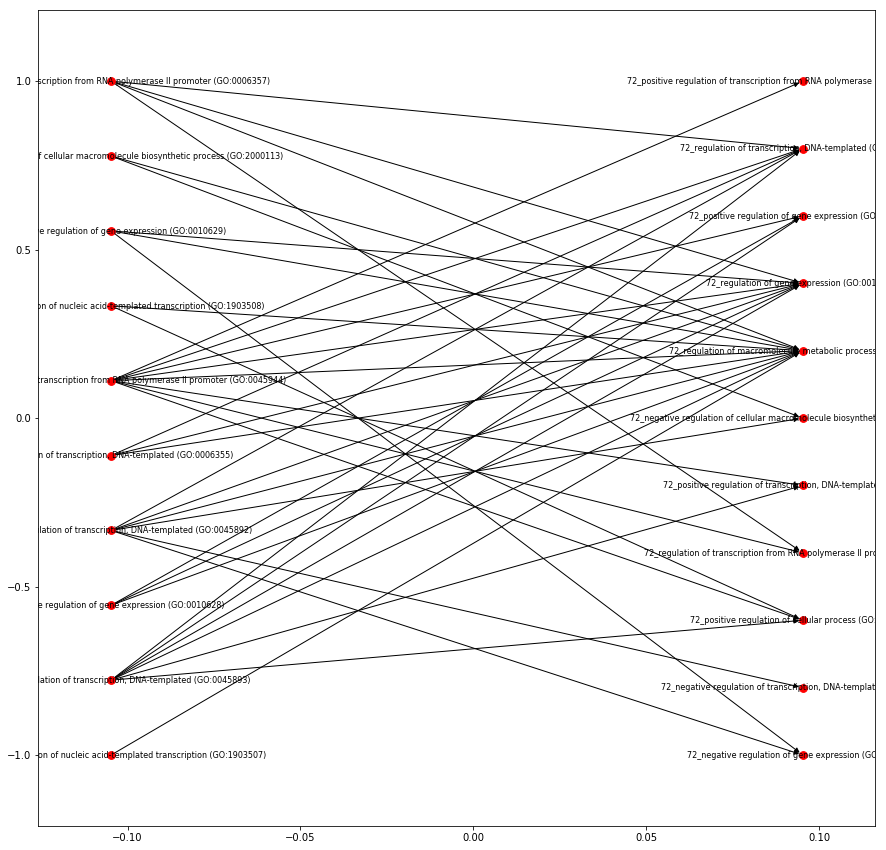

In [110]:
plt.figure(figsize=(15, 15), frameon=False, clear=True)
nx.draw_networkx(
    G,
    pos=nx.drawing.layout.bipartite_layout(G, B_first_partition_nodes, aspect_ratio=.1),
    with_labels=True,
    node_size=60,
    font_size=8,
    edge_colors='#A0CBE2')
plt.autoscale()

In [107]:
for node in B_first_partition_nodes:
    print(node + ' regulates...')
    regulatees = G.neighbors(node)
    regulatees = list(regulatees)
    for regulated in regulatees:
        print('\t' + regulated)

48_positive regulation of transcription, DNA-templated (GO:0045893) regulates...
	72_positive regulation of cellular process (GO:0048522)
	72_positive regulation of transcription, DNA-templated (GO:0045893)
	72_positive regulation of gene expression (GO:0010628)
	72_regulation of gene expression (GO:0010468)
	72_regulation of macromolecule metabolic process (GO:0060255)
	72_regulation of transcription, DNA-templated (GO:0006355)
48_regulation of transcription, DNA-templated (GO:0006355) regulates...
	72_regulation of macromolecule metabolic process (GO:0060255)
	72_regulation of transcription, DNA-templated (GO:0006355)
	72_regulation of gene expression (GO:0010468)
48_positive regulation of nucleic acid-templated transcription (GO:1903508) regulates...
	72_positive regulation of cellular process (GO:0048522)
	72_regulation of macromolecule metabolic process (GO:0060255)
48_positive regulation of gene expression (GO:0010628) regulates...
	72_regulation of macromolecule metabolic proces